In [8]:
import matplotlib
import matplotlib.pyplot
import matplotlib.style
import PIL.Image
import numpy
import sympy
import sympy.printing
import sympy.utilities

matplotlib.rcParams["figure.figsize"] = [12, 6]
matplotlib.style.use("dark_background")
sympy.init_printing(use_latex=True)

In [9]:
# we introduce variables to simplify the equations
# normalised pixel position x 'p_x = x / w'
# normalised pixel position y 'p_y = y / h'
# normalised shear x 'sx = delta * v_x / w'
# normalised shear y 'sy = delta * v_y / h'
# count 'c = delta * rho'
# the condition 'delta * v < w' becomes 's < 1'

# c, p_x, p_y in ]0, +oo[
c, p_x, p_y = sympy.symbols("c p_x p_y", real=True, positive=True)

# s_x, s_y in ]0, 1[
s_x0, s_y0 = sympy.symbols("s_x0 s_y0", real=True, positive=True)
s_x1 = s_x0 + 1
s_y1 = s_y0 + 1
s_x = 1 / s_x1
s_y = 1 / s_y1

f0 = c * p_y / s_y
f1 = c * p_x / s_x
f2 = c * p_y / s_y
f3 = c * p_x / s_x
f4 = c
f5 = c * (1 / s_x - p_x / s_x + p_y / s_y)


In [10]:
integral0: sympy.Expr = sympy.integrate(
    f0, (p_y, 0, s_y / s_x * p_x), (p_x, 0, s_x)
).simplify()
integral1: sympy.Expr = sympy.integrate(
    f1, (p_x, 0, s_x / s_y * p_y), (p_y, 0, s_y)
).simplify()
integral2: sympy.Expr = sympy.integrate(f2, (p_x, s_x, 1), (p_y, 0, s_y)).simplify()
integral3: sympy.Expr = sympy.integrate(f3, (p_x, 0, s_x), (p_y, s_y, 1)).simplify()
integral4: sympy.Expr = sympy.integrate(f4, (p_x, s_x, 1), (p_y, s_y, 1)).simplify()
integral5: sympy.Expr = sympy.integrate(
    f5, (p_y, (p_x - 1) * s_y / s_x, s_y), (p_x, 1, 1 + s_x)
).simplify()

mu_with_assumptions = (
    (
        integral0 * 2
        + integral1 * 2
        + integral2 * 2
        + integral3 * 2
        + integral4
        + integral5 * 2
    )
    / ((1 + s_x) * (1 + s_y) - s_x * s_y)
).simplify()

variance_integral0: sympy.Expr = sympy.integrate(
    (f0 - mu_with_assumptions) ** 2, (p_y, 0, s_y / s_x * p_x), (p_x, 0, s_x)
).simplify()
variance_integral1: sympy.Expr = sympy.integrate(
    (f1 - mu_with_assumptions) ** 2, (p_x, 0, s_x / s_y * p_y), (p_y, 0, s_y)
).simplify()
variance_integral2: sympy.Expr = sympy.integrate(
    (f2 - mu_with_assumptions) ** 2, (p_x, s_x, 1), (p_y, 0, s_y)
).simplify()
variance_integral3: sympy.Expr = sympy.integrate(
    (f3 - mu_with_assumptions) ** 2, (p_x, 0, s_x), (p_y, s_y, 1)
).simplify()
variance_integral4: sympy.Expr = sympy.integrate(
    (f4 - mu_with_assumptions) ** 2, (p_x, s_x, 1), (p_y, s_y, 1)
).simplify()
variance_integral5: sympy.Expr = sympy.integrate(
    (f5 - mu_with_assumptions) ** 2,
    (p_y, (p_x - 1) * s_y / s_x, s_y),
    (p_x, 1, 1 + s_x),
).simplify()

variance_with_assumptions = (
    (
        variance_integral0 * 2
        + variance_integral1 * 2
        + variance_integral2 * 2
        + variance_integral3 * 2
        + variance_integral4
        + variance_integral5 * 2
    )
    / ((1 + s_x) * (1 + s_y) - s_x * s_y)
).simplify()


In [11]:
# re-introduce variables to clear bindings
s_x0, s_y0, s_x1, s_y1, s_x, s_y = sympy.symbols("s_x0 s_y0 s_x1 s_y1 s_x s_y", real=True, positive=True)

mu = mu_with_assumptions.subs(s_x0, 1 / s_x - 1).subs(s_y0, 1 / s_y - 1).simplify().factor()
variance = variance_with_assumptions.subs(s_x0, 1 / s_x - 1).subs(s_y0, 1 / s_y - 1).simplify().factor()

\frac{c}{s_{x} + s_{y} + 1}


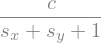

In [12]:
print(sympy.printing.latex(mu))
mu

\frac{c^{2} \left(s_{x}^{2} s_{y} - 2 s_{x}^{2} + s_{x} s_{y}^{2} - 3 s_{x} s_{y} + 4 s_{x} - 2 s_{y}^{2} + 4 s_{y}\right)}{6 \left(s_{x} + s_{y} + 1\right)^{2}}


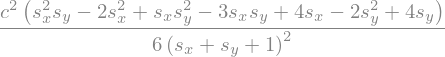

In [13]:
print(sympy.printing.latex(variance))
variance

<function _lambdifygenerated at 0x131186c00>


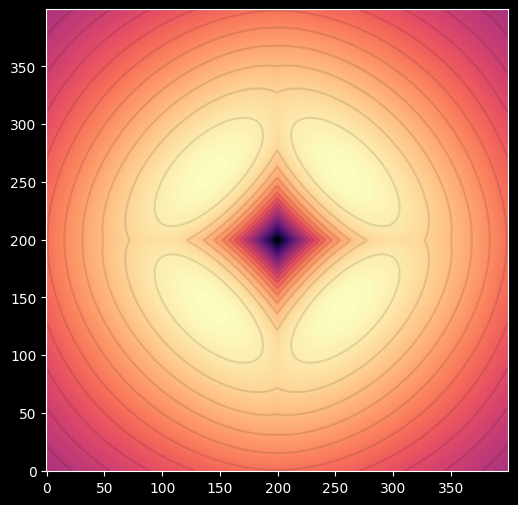

In [15]:
variance_lambda = sympy.utilities.lambdify((s_x, s_y), variance.subs(c, 1.0))
print(variance_lambda)

points = 200
s_x_grid = numpy.repeat(numpy.linspace(0.0, 1.0, points, endpoint=False), points)
s_y_grid = numpy.tile(numpy.linspace(0.0, 1.0, points, endpoint=False), points)

image = PIL.Image.fromarray(
    numpy.vectorize(variance_lambda)(s_x_grid, s_y_grid).reshape((points, points))
)
tiled_image = PIL.Image.new(size=(points * 2, points * 2), mode=image.mode)
tiled_image.paste(image, box=(points, points, points + points, points + points))
tiled_image.paste(
    image.transpose(PIL.Image.Transpose.FLIP_TOP_BOTTOM),
    box=(points, 0, points + points, points),
)
tiled_image.paste(
    image.transpose(PIL.Image.Transpose.FLIP_LEFT_RIGHT),
    box=(0, points, points, points + points),
)
tiled_image.paste(
    image.transpose(PIL.Image.Transpose.ROTATE_180), box=(0, 0, points, points)
)
tiled = numpy.array(tiled_image)

matplotlib.pyplot.imshow(
    tiled,
    origin="lower",
    cmap="magma",
)
matplotlib.pyplot.contour(tiled, levels=20, colors="#000000", alpha=0.1)
